In [24]:
# Initial libraries, seed set, data and model directories, metrics functions

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set(style='whitegrid')
DATA_DIR = r'C:\Users\ASUS\Desktop\F1 Predictions & Visualizations\F1-ML-Project\data\features'
MODEL_DIR = r'C:\Users\ASUS\Desktop\F1 Predictions & Visualizations\F1-ML-Project\data\models'

os.makedirs(MODEL_DIR, exist_ok = True)

def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def r2(y_true, y_pred): return r2_score(y_true, y_pred)

def evaluate_regression(y_true, y_pred):
    return {
        'MAE': float(mae(y_true, y_pred)),
        'RMSE': float(rmse(y_true,y_pred)),
        'R2': float(r2(y_true, y_pred))
    }


In [25]:
df = pd.read_csv(r'C:\Users\ASUS\Desktop\F1 Predictions & Visualizations\F1-ML-Project\data\features\season_2021_round_1_features.csv')


In [26]:
target = 'lap_time'
drop_cols =  ['avg_speed', 'rolling_avg_speed_3', 'max_speed', 'lap_time']

candidate_features = [c for c in df.columns if c not in drop_cols and c not in ['race_name', 'driver_name', 'gp', 'season', 'round', 'race_date']]

num_features = df[candidate_features].select_dtypes(include='number').columns.tolist()
nums_cols = num_features

X = df[num_features].copy()
y = df[target].copy()

groups = df['round'] ## using race/round as the group for GroupKFold
drivers = df['driver_name']

In [27]:
## do this when we're using the full features csv
# rounds = df['round'].unique()
# train_round = np.random.choice(rounds, size = int(len(rounds)*0.7), replace = False)

# train_mask = df['round'].isin(train_round)

#-------------------------------------------------
# for now use 0.7 quantilee


lap_cutoff = df['lap_time'].quantile(0.7)
train_mask = df['lap_time'] <= lap_cutoff
val_mask = df['lap_time'] > lap_cutoff

#--------------------------------------------------

X_train, X_val  = X[train_mask], X[val_mask]
y_train, y_val = y[train_mask], y[val_mask]


In [28]:
## BASELINE 1 - GLOBAL MEAN
## Naive Baseline = Creating a baseline to compare, this is the simplest possible guess
## global mean is the y_train mean, and pred_mean is an array full of the same y_training data mean, basically comparing the mean of the training data
## and the predicted mean, the simplest prediction of the varaince between the training data and the test data, using the simplest metric 

global_mean = y_train.mean()
pred_mean = np.full(len(y_val), global_mean)

evaluate_regression(y_val, pred_mean)


{'MAE': 12.671586027671909,
 'RMSE': 19.608533942106142,
 'R2': -0.7170647587667422}

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

nums_cols = num_features

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0, random_state=RANDOM_SEED))
])


pipeline.fit(X_train[nums_cols], y_train)
pred_lr = pipeline.predict(X_val[nums_cols])
evaluate_regression(y_val, pred_lr)

{'MAE': 1.2314562446804997,
 'RMSE': 1.904778143573486,
 'R2': 0.9837973808271336}

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=12, n_jobs=-1, random_state=RANDOM_SEED)
## fit on training (impute numeric)

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="median")

X_train_imp = imp.fit_transform(X_train)
X_val_imp = imp.transform(X_val)

rf.fit(X_train_imp, y_train)

pred_rf = rf.predict(X_val_imp)
evaluate_regression(y_val, pred_rf)


# Save mode + imputer
joblib.dump({
    'imputer': imp,
    'model' : rf, 
    'features': nums_cols
}, os.path.join(MODEL_DIR, 'rf_baseline.joblib'))


['C:\\Users\\ASUS\\Desktop\\F1 Predictions & Visualizations\\F1-ML-Project\\data\\models\\rf_baseline.joblib']

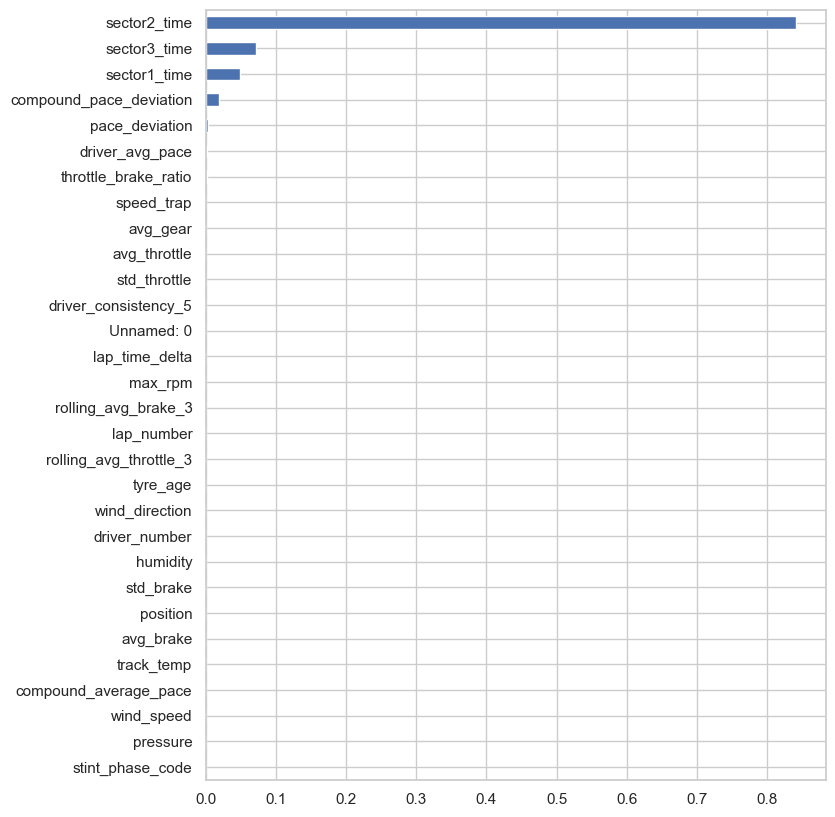

In [31]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index = nums_cols).sort_values(ascending=False)
feat_imp.head(30).plot(kind='barh',figsize=(8,10)); plt.gca().invert_yaxis()

In [32]:
#lightGBM

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

lgb_train = lgb.Dataset(X_train_imp, y_train)
lgb_val = lgb.Dataset(X_val_imp, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'learning_rate': 0.05,
    'num_leaves':31,
    'verbose':-1,
    'seed':RANDOM_SEED
}

callbacks = [
    early_stopping(stopping_rounds = 50),
    log_evaluation(period=50)
]
bst = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val], callbacks=callbacks)

pred_lgb = bst.predict(X_val_imp, num_iteration=bst.best_iteration)
evaluate_regression(y_val, pred_lgb)

joblib.dump({
    'imputer': imp,
    'model':bst,
    'features': nums_cols
}, os.path.join(MODEL_DIR, 'lgb_baseline_joblib'))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.0168549	valid_1's l2: 363.956
[100]	training's l2: 0.00574742	valid_1's l2: 361.302
[150]	training's l2: 0.00401126	valid_1's l2: 360.843
[200]	training's l2: 0.00304761	valid_1's l2: 360.645
[250]	training's l2: 0.00244236	valid_1's l2: 360.509
[300]	training's l2: 0.00200491	valid_1's l2: 360.293
[350]	training's l2: 0.00166652	valid_1's l2: 360.142
[400]	training's l2: 0.00139039	valid_1's l2: 360.003
[450]	training's l2: 0.00116683	valid_1's l2: 359.902
[500]	training's l2: 0.000982222	valid_1's l2: 359.802
[550]	training's l2: 0.000828861	valid_1's l2: 359.711
[600]	training's l2: 0.000704356	valid_1's l2: 359.642
[650]	training's l2: 0.000601276	valid_1's l2: 359.6
[700]	training's l2: 0.000513632	valid_1's l2: 359.563
[750]	training's l2: 0.000437145	valid_1's l2: 359.535
[800]	training's l2: 0.000374823	valid_1's l2: 359.497
[850]	training's l2: 0.000321724	valid_1's l2: 359.452
[900]	training's 

['C:\\Users\\ASUS\\Desktop\\F1 Predictions & Visualizations\\F1-ML-Project\\data\\models\\lgb_baseline_joblib']

In [33]:
results = {
    'global_mean': evaluate_regression(y_val, pred_mean),
    'linear_mean': evaluate_regression(y_val, pred_lr),
    'rf': evaluate_regression(y_val, pred_rf), 
    'lgb': evaluate_regression(y_val, pred_lgb)
}

pd.DataFrame(results).T

,MAE,RMSE,R2
global_mean,12.671586,19.608534,-0.717065
linear_mean,1.231456,1.904778,0.983797
rf,11.513620,19.012552,-0.614274
lgb,11.473529,18.957949,-0.605015


Text(0, 0.5, 'Predicted lap_time')

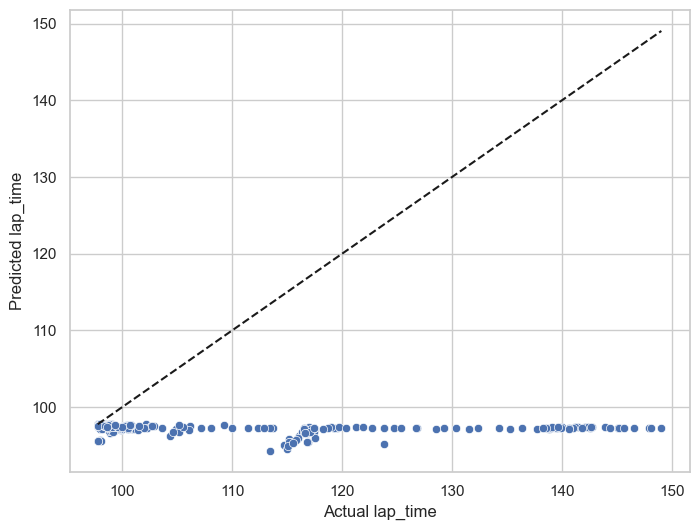

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=pred_lgb)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.xlabel('Actual lap_time'); plt.ylabel('Predicted lap_time')